<a href="https://colab.research.google.com/github/djdongjin/IFT6135-Assignment/blob/master/A1_1_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(1)

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
def one_hot(labels, n):
    """labels: m*1 vector
       n: expected classes
       outout: m*n matrix"""
    m = len(labels)
    onehot = np.zeros((m, n))
    onehot[np.arange(m), labels] = 1
    return onehot

DATA_PATH = r'/content/gdrive/My Drive/app/MNIST'
X_train = np.load(DATA_PATH + '/x_train.npy')
y_train = one_hot(np.load(DATA_PATH + '/y_train.npy'),10)
X_val   = np.load(DATA_PATH + '/x_val.npy')
y_val   = one_hot(np.load(DATA_PATH + '/y_val.npy'),10)
X_test  = np.load(DATA_PATH + '/x_test.npy')
y_test  = one_hot(np.load(DATA_PATH + '/y_test.npy'),10)

FileNotFoundError: ignored

In [0]:
def accuracy(y_pred, y):
    return np.sum(1 * np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) * 100.0 / y.shape[0]


def data_iter(data, batch_size):
    X, y = data
    batches = [(X[i:i+batch_size],y[i:i+batch_size]) for i in range(0,X.shape[0],batch_size)]
    random.shuffle(batches)
    for batch in batches:
        yield batch
                
        
def glorot(in_dim, out_dim):
    d = np.sqrt(6/(in_dim+out_dim))
    return np.random.uniform(-d,d,(in_dim,out_dim))

In [0]:
INPUT_DIM = 784
OUTPUT_DIM = 10

class NN(object):
    
    
    def __init__(self,hidden_dims=[1024,2048],n_hidden=2,init='Normal',activate='relu'):
        self.dims = [INPUT_DIM,] + hidden_dims + [OUTPUT_DIM,]
        self.weights = []
        self.biases  = []
        self.init = init
        self.activate = activate
        
        self.initialize_weights(n_hidden, self.dims)
        
        
    def initialize_weights(self, n_hidden, dims):
        init_method = None
        if self.init == 'Zero':
            init_method = lambda x, y: np.zeros((x,y))
        elif self.init == 'Normal':
            init_method = lambda x, y: np.random.randn(x,y)
        elif self.init == 'Glorot':
            init_method = glorot
        else:
            raise Exception('Choose right initialization method.')
            
        for (inputs, outputs) in zip(dims[:-1], dims[1:]):
            self.weights.append(init_method(inputs, outputs))
            self.biases.append(np.zeros(outputs))
            
            
    def activation(self,inputs):
        if self.activate == 'relu':
            inputs[inputs < 0] = 0
            return inputs
        if self.activate == 'sigmoid':
            return 1.0/(1.0+np.exp(-inputs))

        
    def loss(self, pred, labels):
        '''
        Negative log likelihood
        '''
        ls = np.nan_to_num(np.log(pred))
        ls = - np.sum(labels * ls)
        return ls / pred.shape[0]
            
        
    def forward(self, inputs, labels):
        a_k = None
        h_k = inputs
        a = []
        h = [h_k]
        for (W, b) in zip(self.weights[:-1], self.biases[:-1]):
            a_k = np.dot(h_k, W) + b
            h_k = self.activation(a_k)
            a.append(a_k)
            h.append(h_k)
        
        a_k = np.dot(h_k, self.weights[-1]) + self.biases[-1]
        h_k = self.softmax(a_k)
        a.append(a_k)
        h.append(h_k)
        
        ls = self.loss(h_k, labels)
        cache = (a, h)
        
        return h_k, ls, cache
    
    
    def backward(self,cache,labels,lss):
        """
        Input: cache: (as, hs)
                    as: preactivate values
                    hs: activated values
                    lss: loss
        output: grads: (grads_w, grads_b)
        """
        as_ = cache[0]
        hs_ = cache[1]
        
        nabla_w = [np.zeros_like(w) for w in self.weights]
        nabla_b = [np.zeros_like(b) for b in self.biases]

        # nabla l -> softmax -> pre-softmax
        nabla_a = -(labels - hs_[-1])
        nabla_b[-1] = np.sum(nabla_a, axis=0)
        nabla_w[-1] = np.dot(hs_[-2].T, nabla_a)
        # for each preactivate -> activation layer
        for layer in range(2, len(self.dims)):
            nabla_h = np.dot(nabla_a, self.weights[-layer+1].T)
            nabla_a = nabla_h * self.activate_grad(as_[-layer])

            nabla_b[-layer] = np.sum(nabla_a, axis=0)
            nabla_w[-layer] = np.dot(hs_[-layer-1].T, nabla_a)

        nabla_w = [x / labels.shape[0] for x in nabla_w]
        nabla_b = [x / labels.shape[0] for x in nabla_b]
        return (nabla_w,nabla_b)
   
        
    def update(self,grads,lr):
        grads_w, grads_b = grads
        for i in range(len(self.weights)):
            self.weights[i] -= lr * grads_w[i]
            self.biases[i] -= lr * grads_b[i]
            

    def train(self, data, epochs, batch_size, lr, lambd=0.0, test_data=None):
        l_acc = []
        l_ls  = []
        for ep in range(1, epochs+1):
            print('Epoch',ep,':')
            for (batch_x, batch_y) in data_iter(data, batch_size):
                y_pred, ls, cache = self.forward(batch_x, batch_y)
                grads = self.backward(cache, batch_y, ls)
                self.update(grads, lr)
            if test_data:
                acc, ls = self.test(test_data)
                l_acc.append(acc)
                l_ls.append(ls)
                print('Epoch %i (acc, loss):(%s,%s)' % (ep, acc, ls))
        return l_acc, l_ls

                
    def test(self, data):
        x, y = data
        outputs, ls, _ = self.forward(x, y)
        return accuracy(outputs, y), ls
        
    
    def activate_grad(self,inputs):
        if self.activate == 'relu':
            inputs[inputs > 0] = 1
            inputs[inputs < 0] = 0
            return inputs
        elif self.activate == 'sigmiod':
            return self.activation(inputs) * (1 - self.activation(inputs))
        
        
    def softmax(self,inputs):
        inputs = inputs - np.max(inputs, axis=1).reshape(inputs.shape[0],1)
        outputs = np.exp(inputs)
        return outputs / (np.sum(outputs, axis=1).reshape(inputs.shape[0],1))
        

## Initialization

number of hidden units per layer:
total number of parameters:
nonlinearity activation:
learning rate:
mini-batch size:

Epoch 1 :
Epoch 1 (acc, loss):(11.356,2.301961069176031)
Epoch 2 :
Epoch 2 (acc, loss):(11.356,2.301582395951002)
Epoch 3 :
Epoch 3 (acc, loss):(11.356,2.301355417424963)
Epoch 4 :
Epoch 4 (acc, loss):(11.356,2.3012182355760977)
Epoch 5 :
Epoch 5 (acc, loss):(11.356,2.3011347759450222)
Epoch 6 :
Epoch 6 (acc, loss):(11.356,2.301085424407625)
Epoch 7 :
Epoch 7 (acc, loss):(11.356,2.3010559319781496)
Epoch 8 :
Epoch 8 (acc, loss):(11.356,2.3010386676388674)
Epoch 9 :
Epoch 9 (acc, loss):(11.356,2.3010277734997646)
Epoch 10 :
Epoch 10 (acc, loss):(11.356,2.301021417323032)
Epoch 1 :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Epoch 1 (acc, loss):(91.21,inf)
Epoch 2 :
Epoch 2 (acc, loss):(93.836,inf)
Epoch 3 :
Epoch 3 (acc, loss):(95.07,inf)
Epoch 4 :
Epoch 4 (acc, loss):(95.67,inf)
Epoch 5 :
Epoch 5 (acc, loss):(96.702,inf)
Epoch 6 :
Epoch 6 (acc, loss):(97.366,inf)
Epoch 7 :
Epoch 7 (acc, loss):(98.032,inf)
Epoch 8 :
Epoch 8 (acc, loss):(98.156,inf)
Epoch 9 :
Epoch 9 (acc, loss):(98.55,inf)
Epoch 10 :
Epoch 10 (acc, loss):(98.784,3.5953862697246315e+303)
Epoch 1 :
Epoch 1 (acc, loss):(83.876,0.7916546061448241)
Epoch 2 :
Epoch 2 (acc, loss):(87.626,0.5037904637246717)
Epoch 3 :
Epoch 3 (acc, loss):(89.142,0.41305929256269913)
Epoch 4 :
Epoch 4 (acc, loss):(90.174,0.366835801773168)
Epoch 5 :
Epoch 5 (acc, loss):(90.712,0.3379712801492887)
Epoch 6 :
Epoch 6 (acc, loss):(91.24,0.31695695968705934)
Epoch 7 :
Epoch 7 (acc, loss):(91.652,0.30067185838911853)
Epoch 8 :
Epoch 8 (acc, loss):(91.994,0.28745810885123585)
Epoch 9 :
Epoch 9 (acc, loss):(92.318,0.27622436942075296)
Epoch 10 :
Epoch 10 (acc, loss):(92.5

AttributeError: ignored

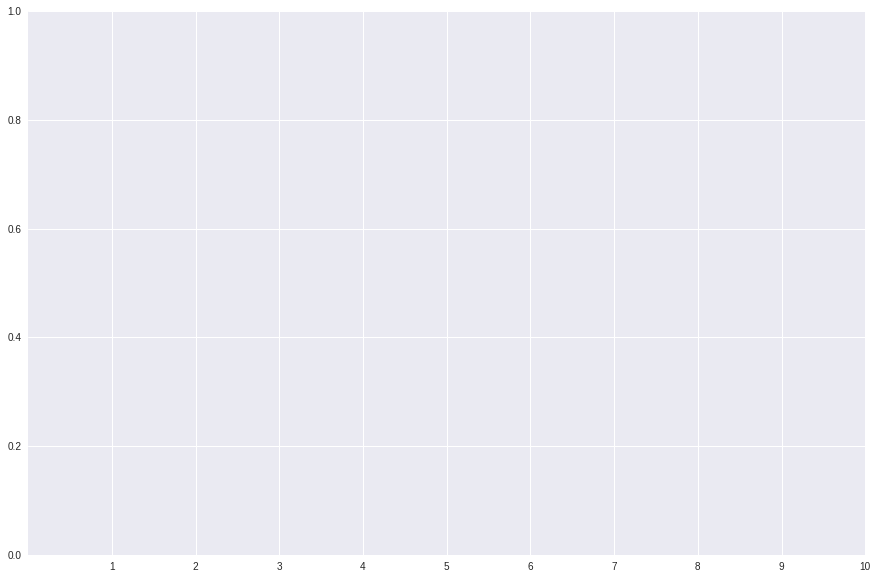

In [87]:
nn1 = NN(hidden_dims=[900,600],n_hidden=2,init='Zero')
zero_acc, zero_ls = nn1.train((X_train,y_train), epochs=10, batch_size=200, lr=0.01, test_data=(X_train,y_train))
nn2 = NN(hidden_dims=[900,600],n_hidden=2,init='Normal')
normal_acc, normal_ls = nn2.train((X_train,y_train), epochs=10, batch_size=200, lr=0.01, test_data=(X_train,y_train))
nn3 = NN(hidden_dims=[900,600],n_hidden=2,init='Glorot')
glorot_acc, glorot_ls = nn3.train((X_train,y_train), epochs=10, batch_size=200, lr=0.01, test_data=(X_train,y_train))

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

plt.xticks(np.arange(0, 11, step=1))
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Average Loss on Training Set', weight='bold')
plt.title('Empirical Risk - Training Set - MNIST - 3 Different Initialization Methods', weight='bold')

plt.plot(np.arange(1, 11, step=1), normal_acc, label='Normal')
plt.plot(np.arange(1, 11, step=1), glorot_acc, label='Glorot')
plt.plot(np.arange(1, 11, step=1), zero_acc, label='Zero')
plt.legend()
plt.show()

## Parameter Search
Architecture : 784 -> 666 -> 666 -> 10 (973,702 parameters)
Nonlinearity : ReLU
Learning rate : 0.1
Mini-batch size : 100
Numpy random seed : 0
Initialization : Glorot

In [89]:
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=100, lr=0.1, test_data=(X_val,y_val))


Epoch 1 :
Epoch 1 (acc, loss):(94.05,0.20935447554445294)
Epoch 2 :
Epoch 2 (acc, loss):(95.99,0.1478667828157328)
Epoch 3 :
Epoch 3 (acc, loss):(96.61,0.12020052887266927)
Epoch 4 :
Epoch 4 (acc, loss):(97.07,0.10148065573105852)
Epoch 5 :
Epoch 5 (acc, loss):(97.19,0.09322777999335484)
Epoch 6 :
Epoch 6 (acc, loss):(97.36,0.08999020176704418)
Epoch 7 :
Epoch 7 (acc, loss):(97.53,0.08053558622466704)
Epoch 8 :
Epoch 8 (acc, loss):(97.67,0.08124906043340971)
Epoch 9 :
Epoch 9 (acc, loss):(97.81,0.07730418018852951)
Epoch 10 :
Epoch 10 (acc, loss):(97.77,0.07211707192557472)


## Validate Gradients using Finite Diﬀerence

2.6392597639551267
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


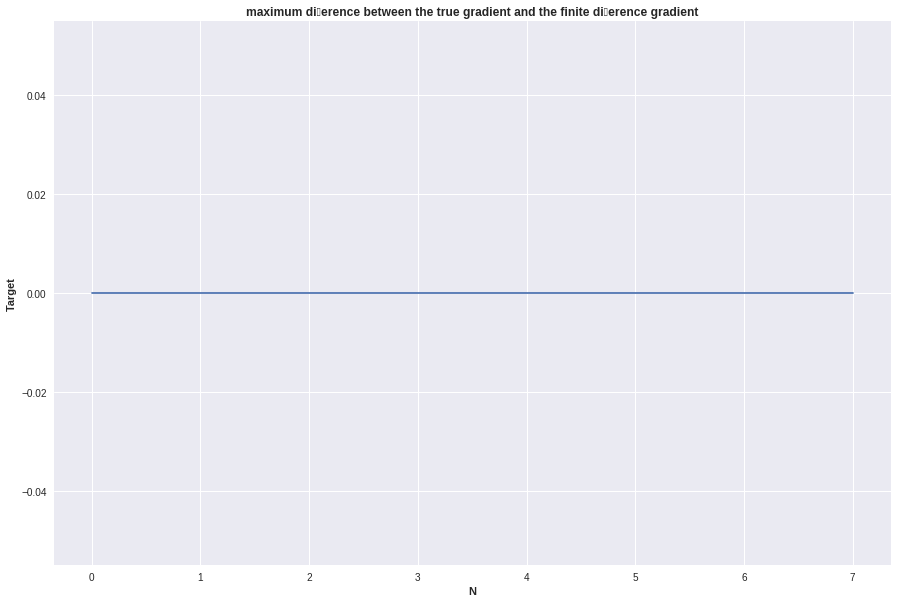

In [111]:
#
nn5 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
i_value = [0,1,3,5]
k_value = [1,5]
N_value = [k*10**i for i in i_value for k in k_value]
p = 10

data_number = np.random.randint(0,X_train.shape[0])
X, y = X_train[data_number,:].reshape(1,-1), y_train[data_number,:].reshape(1,-1)
y_hat, ls, cache = nn5.forward(X,y)
print(ls)
grad_W, grad_b = nn5.backward(cache, y, ls)

grad_theta = grad_W[0][0,:p]

res = []

for N in N_value:
    epsilon = 1 / N
    grad_diff = np.zeros(p)
    for i in range(p):
        
        nn5.weights[0][0,i] += epsilon
        _, L_plus, _ = nn5.forward(X,y)
        
        nn5.weights[0][0,i] -= 2*epsilon
        _, L_minus,_ = nn5.forward(X,y)
        
        nn5.weights[0][0,i] += epsilon
        
        grad_diff[i] = (L_plus/epsilon-L_minus/epsilon) / 2
    res.append(np.max(np.abs(grad_theta - grad_diff)))
    
plt.xlabel('N', weight='bold')
plt.ylabel('Target', weight='bold')
plt.title('maximum diﬀerence between the true gradient and the ﬁnite diﬀerence gradient', weight='bold')
plt.plot(np.arange(len(res)), res)    

In [0]:
?plt.plot